In [1]:
import torch as t


计算
$$
a(x, w, b)=relu(w\cdot x + b)
$$

计算图：

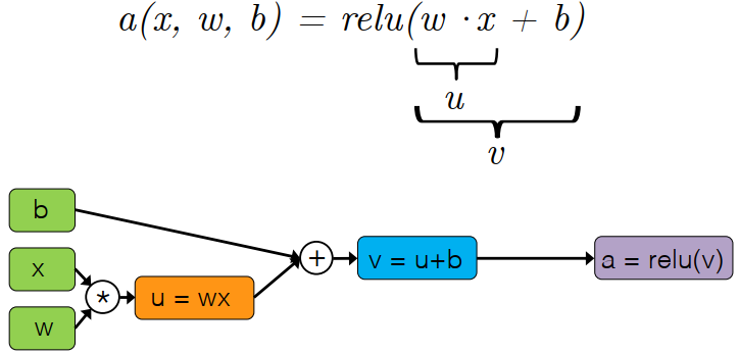

In [2]:
# 调用backward计算梯度
b = t.tensor(1.0, requires_grad=True)
w = t.tensor(2.0, requires_grad=True)
x = t.tensor(3.0)
u = w * x
v = u + b
a = t.relu(v)
a.backward()
print(b.grad)
print(w.grad)

tensor(1.)
tensor(3.)


In [3]:
u.grad

/var/folders/4m/kw1nckdn0qzcz68fpxyc8yj80000gn/T/ipykernel_54501/3542285320.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1684998575025/work/build/aten/src/ATen/core/TensorBody.h:492.)
  u.grad


In [4]:
b = t.tensor(1.0, requires_grad=True)
w = t.tensor(2.0, requires_grad=True)
x = t.tensor(3.0)
u = w * x
u.retain_grad()
v = u + b
v.retain_grad()
a = t.relu(v)
a.backward()
print("da/dv", v.grad)
print("da/du", u.grad)
print("da/db", b.grad)
print("da/dw", w.grad)

da/dv tensor(1.)
da/du tensor(1.)
da/db tensor(1.)
da/dw tensor(3.)


计算图上的梯度计算过程：

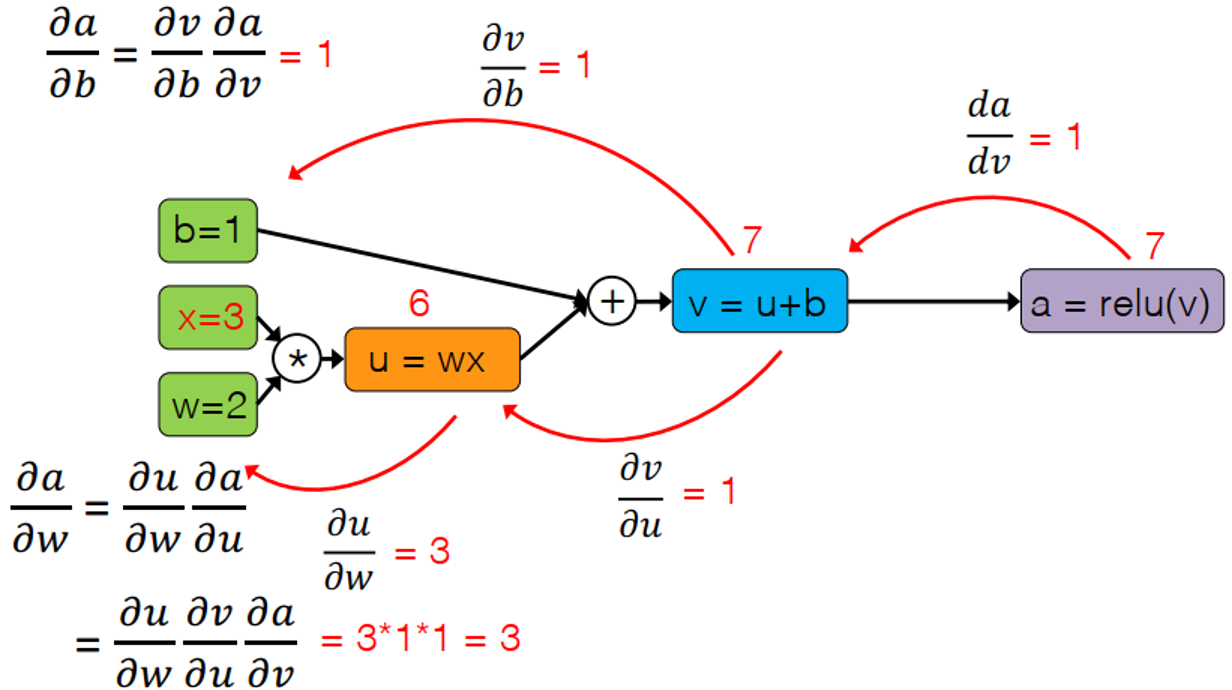

In [5]:
# 前向计算，得到a
b = t.tensor(1.0, requires_grad=True)
w = t.tensor(2.0, requires_grad=True)
x = t.tensor(3.0)
u = w * x
v = u + b
a = t.relu(v)
a

tensor(7., grad_fn=<ReluBackward0>)

In [6]:
#计算da/dv, 其中1.0可以理解为da/da=1.0
dv = a.grad_fn(t.tensor(1.0)) 
dv

tensor(1., grad_fn=<ThresholdBackwardBackward0>)

In [7]:
#从grad_fn.next_functions里获取得到v的上一步计算过程（的梯度计算函数）
print(a.grad_fn.next_functions)
print(v.grad_fn)
# 获得计算v的函数对应的梯度计算函数
v_grad_fn = a.grad_fn.next_functions[0][0]
# 该函数可以计算da/du, da/db,其值分别等于da/dv*dv/du, da/dv*dv/db，注意这里需要将上一步得到da/dv”反向传播“给grad_fn
du, db = v_grad_fn(dv)
print(du, db)

((<AddBackward0 object at 0x125f3fbe0>, 0),)
tensor(1., grad_fn=<ThresholdBackwardBackward0>) tensor(1., grad_fn=<ThresholdBackwardBackward0>)


In [8]:
#我们可以进一步递归的得到计算u和b的计算过程（和梯度计算函数）
#注意，由于v是由u和b两个张量计算得到的，所以其grad_fn里包含的next_functions会分别包含计算u和计算b的函数
print(v_grad_fn.next_functions)
u_grad_fn, b_grad_fn = v_grad_fn.next_functions
u_grad_fn, b_grad_fn = u_grad_fn[0], b_grad_fn[0]

((<MulBackward0 object at 0x125f3ee60>, 0), (<AccumulateGrad object at 0x125f3f0d0>, 0))


In [9]:
# b是一个requires_grad=True，is_leaf=True的节点，它的grad_fn是个特殊的函数，它的作用是将da/db累加到b.grad里
# 思考一下，为什么要进行累加
print(b.grad)
b_grad_fn(db)
print(b.grad)

None
tensor(1., grad_fn=<CopyBackwards>)


In [10]:
#使用u的grad_fn可以计算da/dw和da/dx，分别等于da/du*du/dw, da/du*du/dx，同样需要将da/du“反向传播”给grad_fn
dw, dx = u_grad_fn(du)

print(dw, dx) # 由于x.requires_grad = False, dx会为None

#由于u是由w和x两个张量计算得到的，所以其grad_fn里包含的next_functions会分别包含计算w和计算x的函数
w_grad_fn, x_grad_fn = u.grad_fn.next_functions

#由于x.requires_grad=False,所以x_grad_fn是None
print(x_grad_fn[0])

# w是一个requires_grad=True，is_leaf=True的节点，它的grad_fn是个特殊的函数，它的作用是将da/dw保存到w.grad里
print(w_grad_fn[0])
print(w.grad)
w_grad_fn[0](dw)
print(w.grad)

tensor(3., grad_fn=<MulBackward0>) None
None
None
tensor(3., grad_fn=<CopyBackwards>)


In [11]:
print(b.grad)
print(w.grad)

tensor(1., grad_fn=<CopyBackwards>)
tensor(3., grad_fn=<CopyBackwards>)


In [15]:
# 自定义 Function，实现 forward 和 backward
import torch.nn as nn
class SquareFunction(t.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input ** 2

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = 2 * input * grad_output
        return grad_input

# 自定义 Module，只负责 forward
class MySquare(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return SquareFunction.apply(input)

tensor(4.)


In [17]:
# 测试
model = MySquare()

x = t.tensor(2.0, requires_grad=True)
y = model(x)
y.backward()

print(x.grad)  # 输出 4.0，符合 dy/dx = 2x


tensor(4.)


In [19]:
x = t.tensor(1.0, requires_grad=True)
y = model(x)
y.backward()

print(x.grad)  # 输出 2.0，符合 dy/dx = 2x

tensor(2.)


In [23]:
x = t.tensor(1.0, requires_grad=True)
y = model(x)
# y的grad_fn
y.grad_fn

In [24]:
# 自定义 Function，实现 forward 和 backward
import torch.nn as nn
class SquareAddFunction(t.autograd.Function):
    @staticmethod
    def forward(ctx, x, y):
        ctx.save_for_backward(x, y)
        return x**2 + y**2

    @staticmethod
    def backward(ctx, grad_output):
        x, y, = ctx.saved_tensors
        dx = 2 * x * grad_output
        dy = 2 * y * grad_output
        return dx, dy

# 自定义 Module，只负责 forward
class SquareAdd(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        return SquareAddFunction.apply(x, y)

In [35]:
x = t.tensor(3.0, requires_grad=True)
y = t.tensor(2.0, requires_grad=True)
z = SquareAdd()(x, y)
z.backward()

In [36]:
z.grad_fn

In [37]:
x.grad

tensor(6.)

In [34]:
y.grad

tensor(4.)